<a href="https://colab.research.google.com/github/Sarvesh0827/Client-Mern1/blob/main/TESLA_STOCK_PRICE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import string
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.layers import Dense, Dropout, Bidirectional

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
df_tsla_tweet = pd.read_csv('/content/tesla_tweets_data.csv')

In [15]:
df_tsla_tweet

,id,date,tweet
0,1.212450e+18,02-01-2020,Fun fact: Audi registered more E-Tron's in the...
1,1.212450e+18,02-01-2020,That MF TSLA stock at 420.. I watch that shit ...
2,1.212450e+18,02-01-2020,@ICannot_Enough And on June 5 th 2019 within 2...
3,1.212450e+18,02-01-2020,Tesla is gaining momentum in Taiwan 🇹🇼 @TeslaO...
4,1.212450e+18,02-01-2020,@Schuldensuehner Now extrapolate these numbers...
...,...,...,...
113736,1.344760e+18,01-01-2021,#TSLA whales stepping in for the last day of t...
113737,1.344760e+18,01-01-2021,I’ve always wanted to get into investing and t...
113738,1.344760e+18,01-01-2021,@RampCapitalLLC $OPEN little buddy told me is ...
113739,1.344760e+18,01-01-2021,Fantastic week. Thanks for the huge support in...


In [16]:
df_tsla_stock = pd.read_csv('/content/tesla_stock_data.csv')

In [17]:
df_tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
248,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
249,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
250,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
251,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000


In [18]:
df_tsla_tweet = df_tsla_tweet.groupby('date').agg({'tweet': ' '.join}).reset_index()

Lower Case Conversion

In [19]:
for i in range(df_tsla_tweet.shape[0]):
    df_tsla_tweet['tweet'][i] = df_tsla_tweet['tweet'][i].lower()

Remove Punctuation

In [20]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

Remove Stop words

In [21]:
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')

In [22]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

In [23]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda x: remove_stopwords(x))

In [24]:
df_tsla_tweet

,date,tweet
0,01-01-2020,tsla tesla faces lawsuit claiming racism https...
1,01-01-2021,happy new year everyone even tsla short seller...
2,01-02-2020,electrekco michelle0728 cannot build tsla with...
3,01-03-2020,😳😳😳😳😳 350km electric vehicle would driving 25 ...
4,01-04-2020,tesl “earnings” inflated least 200m per q due ...
...,...,...
362,31-05-2020,tsla ita เตง ฉันว่าคนละโพดีกว่าคนละเรือ อย่าเค...
363,31-07-2020,garyblack00 elonmusk tsla wont need split wait...
364,31-08-2020,shanekinguk sincerely hope ev companies surviv...
365,31-10-2020,tesla inc tsla price close 20201030 38804 gfil...


In [25]:
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: re.sub(r'http.*', '', x))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: re.sub(r'[^a-zA-Z#]', ' ', x))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('tesla', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('tsla', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('q', ''))
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].map(lambda x: x.replace('#', ''))

Lemmatization

In [26]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df_tsla_tweet['tweet'] = df_tsla_tweet['tweet'].apply(lambda text: lemmatize_words(text))

In [27]:
df_tsla_tweet

,date,tweet
0,01-01-2020,face lawsuit claiming racism
1,01-01-2021,happy new year everyone even short seller hell...
2,01-02-2020,electrekco michelle cannot build without oil y...
3,01-03-2020,km electric vehicle would driving million kilo...
4,01-04-2020,tesl earnings inflated least m per due massive...
...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...
363,31-07-2020,garyblack elonmusk wont need split wait two mo...
364,31-08-2020,shanekinguk sincerely hope ev company survive ...
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...


In [28]:
temp_list = []
for i in range(len(df_tsla_tweet['tweet'])):
    tokens = word_tokenize(df_tsla_tweet['tweet'][i])
    temp_list.append(tokens)
df_tsla_tweet['tokenized tweet'] = temp_list

In [29]:
df_tsla_tweet

,date,tweet,tokenized tweet
0,01-01-2020,face lawsuit claiming racism,"[face, lawsuit, claiming, racism]"
1,01-01-2021,happy new year everyone even short seller hell...,"[happy, new, year, everyone, even, short, sell..."
2,01-02-2020,electrekco michelle cannot build without oil y...,"[electrekco, michelle, can, not, build, withou..."
3,01-03-2020,km electric vehicle would driving million kilo...,"[km, electric, vehicle, would, driving, millio..."
4,01-04-2020,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,..."
...,...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...,"[ita, anti, elon, shill, going, continue, call..."
363,31-07-2020,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,..."
364,31-08-2020,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su..."
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...,"[inc, price, close, gfilche, buy, pogiboi, san..."


In [31]:
df_tsla_stock.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [32]:
df_tsla_stock['Date'] = pd.to_datetime(df_tsla_stock['Date'], dayfirst=True)
df_tsla_stock = df_tsla_stock[df_tsla_stock['Date'].isin(pd.date_range('2020-01-02', '2021-01-01'))]
df_tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
248,2020-12-24,214.330002,222.029999,213.666672,220.589996,220.589996,68596800
249,2020-12-28,224.836670,227.133331,220.266663,221.229996,221.229996,96835800
250,2020-12-29,220.333328,223.300003,218.333328,221.996674,221.996674,68732400
251,2020-12-30,224.000000,232.199997,222.786667,231.593338,231.593338,128538000


Sentiment Score


In [33]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [35]:
sentimentAnalyser = SentimentIntensityAnalyzer()

In [36]:
def calculate_sentiment_vader(text):
    scores = sentimentAnalyser.polarity_scores(text)
    compound_score = scores['compound']
    return compound_score

In [37]:
df_tsla_tweet['sentiment score'] = df_tsla_tweet['tweet'].apply(calculate_sentiment_vader)
# df_tsla_tweet['sentiment score_tb'] = df_tsla_tweet['tweet'].apply(calculate_sentiment_textblob)

In [38]:
df_tsla_tweet

,date,tweet,tokenized tweet,sentiment score
0,01-01-2020,face lawsuit claiming racism,"[face, lawsuit, claiming, racism]",-0.7184
1,01-01-2021,happy new year everyone even short seller hell...,"[happy, new, year, everyone, even, short, sell...",0.7328
2,01-02-2020,electrekco michelle cannot build without oil y...,"[electrekco, michelle, can, not, build, withou...",0.0000
3,01-03-2020,km electric vehicle would driving million kilo...,"[km, electric, vehicle, would, driving, millio...",0.0000
4,01-04-2020,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,...",-0.7269
...,...,...,...,...
362,31-05-2020,ita anti elon shill going continue call fruad ...,"[ita, anti, elon, shill, going, continue, call...",0.8074
363,31-07-2020,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,...",0.5994
364,31-08-2020,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su...",0.9476
365,31-10-2020,inc price close gfilche buy pogiboi sandropowe...,"[inc, price, close, gfilche, buy, pogiboi, san...",0.7717


In [39]:
df_tsla_tweet.dtypes

date                object
tweet               object
tokenized tweet     object
sentiment score    float64
dtype: object

In [40]:
df_tsla_tweet['date'] = pd.to_datetime(df_tsla_tweet['date'], dayfirst=True)

In [41]:
df = pd.merge(df_tsla_tweet, df_tsla_stock, how='inner', left_on = 'date', right_on = 'Date')
df

,date,tweet,tokenized tweet,sentiment score,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-01,tesl earnings inflated least m per due massive...,"[tesl, earnings, inflated, least, m, per, due,...",-0.7269,2020-04-01,33.599998,34.263332,31.673332,32.104000,32.104000,200298000
1,2020-05-01,dougkass cnbc f b rev b cash v bubble balance ...,"[dougkass, cnbc, f, b, rev, b, cash, v, bubble...",0.5267,2020-05-01,50.333332,51.518002,45.535999,46.754665,46.754665,487977000
2,2020-06-01,erpauditor tictoctick higher chance yes discla...,"[erpauditor, tictoctick, higher, chance, yes, ...",0.8658,2020-06-01,57.200001,59.933334,56.939999,59.873333,59.873333,224092500
3,2020-07-01,level close danahull paying elonmusk musk almo...,"[level, close, danahull, paying, elonmusk, mus...",0.0000,2020-07-01,72.199997,75.688667,72.033333,74.641998,74.641998,199903500
4,2020-09-01,loving new setup far vvpr spy,"[loving, new, setup, far, vvpr, spy]",0.5994,2020-09-01,167.380005,167.496674,156.836670,158.350006,158.350006,269523300
...,...,...,...,...,...,...,...,...,...,...,...
248,2020-01-31,concern lack capex guidance stat depreciation ...,"[concern, lack, capex, guidance, stat, depreci...",-0.4019,2020-01-31,42.666668,43.533333,42.167999,43.371334,43.371334,235789500
249,2020-03-31,caranddriver twitter laughably shit im waiting...,"[caranddriver, twitter, laughably, shit, im, w...",-0.8591,2020-03-31,33.416668,36.197334,33.133331,34.933334,34.933334,266572500
250,2020-07-31,garyblack elonmusk wont need split wait two mo...,"[garyblack, elonmusk, wont, need, split, wait,...",0.5994,2020-07-31,101.000000,101.136665,94.732002,95.384003,95.384003,183123000
251,2020-08-31,shanekinguk sincerely hope ev company survive ...,"[shanekinguk, sincerely, hope, ev, company, su...",0.9476,2020-08-31,148.203339,166.713333,146.703339,166.106674,166.106674,355123200


In [42]:
raw_df = df.copy()

In [43]:
df = df[['Date','High','Low','Open','Close','Adj Close','Volume','sentiment score']]

In [44]:
df

,Date,High,Low,Open,Close,Adj Close,Volume,sentiment score
0,2020-04-01,34.263332,31.673332,33.599998,32.104000,32.104000,200298000,-0.7269
1,2020-05-01,51.518002,45.535999,50.333332,46.754665,46.754665,487977000,0.5267
2,2020-06-01,59.933334,56.939999,57.200001,59.873333,59.873333,224092500,0.8658
3,2020-07-01,75.688667,72.033333,72.199997,74.641998,74.641998,199903500,0.0000
4,2020-09-01,167.496674,156.836670,167.380005,158.350006,158.350006,269523300,0.5994
...,...,...,...,...,...,...,...,...
248,2020-01-31,43.533333,42.167999,42.666668,43.371334,43.371334,235789500,-0.4019
249,2020-03-31,36.197334,33.133331,33.416668,34.933334,34.933334,266572500,-0.8591
250,2020-07-31,101.136665,94.732002,101.000000,95.384003,95.384003,183123000,0.5994
251,2020-08-31,166.713333,146.703339,148.203339,166.106674,166.106674,355123200,0.9476


Prediction without sentiment scores LSTM


In [45]:
X_1 = df.drop(['Date', 'Adj Close','sentiment score'], axis = 1)
y_1 = df.iloc[:, 4:5]

In [46]:
# X = df[['sentiment score']]

In [47]:
scaler = MinMaxScaler()
X_normalized_1 = scaler.fit_transform(X_1)
y_normalized_1 = scaler.fit_transform(y_1)

i_split = int(len(df) * 0.9)

X_train_1 = X_normalized_1[:i_split, :]
y_train_1 = y_normalized_1[:i_split, :]
X_test_1 = X_normalized_1[i_split:,:]
y_test_1 = y_normalized_1[i_split:,:]

In [48]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
X_train_new_1 = np.reshape(X_train_1,(X_train_1.shape[0],X_train_1.shape[1],1))

In [52]:
model_1 = Sequential()

model_1.add(LSTM(units = 5,kernel_initializer='glorot_uniform',return_sequences=True,input_shape=(X_train_new_1.shape[1],1)))

model_1.add(LSTM(units = 2,kernel_initializer='glorot_uniform'))

model_1.add(Dense(units=1))

In [53]:
model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_1.fit(X_train_1, y_train_1, batch_size = 10, epochs = 10)

Epoch 1/10
23/23 [==============================] - 8s 15ms/step - loss: 0.1592
Epoch 2/10
23/23 [==============================] - 0s 13ms/step - loss: 0.1159
Epoch 3/10
23/23 [==============================] - 0s 12ms/step - loss: 0.0850
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0641
Epoch 5/10
23/23 [==============================] - 0s 12ms/step - loss: 0.0523
Epoch 6/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0441
Epoch 7/10
23/23 [==============================] - 1s 23ms/step - loss: 0.0365
Epoch 8/10
23/23 [==============================] - 0s 22ms/step - loss: 0.0284
Epoch 9/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 10/10
23/23 [==============================] - 0s 18ms/step - loss: 0.0107


In [54]:
model_1.save('/content/drive/MyDrive/BeProject/model_1.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
model_1 = load_model('/content/drive/MyDrive/BeProject/model_1.h5')

In [56]:
X_test_new_1 = np.reshape(X_test_1,(X_test_1.shape[0],X_test_1.shape[1],1))
predicted_value_1 = model_1.predict(X_test_new_1)

1/1 [==============================] - 2s 2s/step


In [57]:
y_test_1

array([[0.58481339],
       [0.55090254],
       [0.52693763],
       [0.93372549],
       [0.0693909 ],
       [0.13870286],
       [0.14959286],
       [0.2046427 ],
       [0.35928112],
       [0.54753991],
       [0.53453126],
       [0.93735659],
       [0.08827868],
       [0.04449139],
       [0.13282056],
       [0.22688998],
       [0.35561219],
       [0.56323231],
       [0.49855232],
       [0.78202664],
       [0.98280783],
       [0.09136032],
       [0.0513967 ],
       [0.33770009],
       [0.67265321],
       [1.        ]])

In [58]:
predicted_value_1

array([[0.5626453 ],
       [0.52094775],
       [0.50350577],
       [0.7050685 ],
       [0.15796149],
       [0.19850445],
       [0.19915947],
       [0.23260301],
       [0.3700177 ],
       [0.5174557 ],
       [0.5019272 ],
       [0.69937795],
       [0.18006137],
       [0.14042047],
       [0.21886316],
       [0.25730303],
       [0.36297145],
       [0.5246046 ],
       [0.4893845 ],
       [0.6603774 ],
       [0.71262616],
       [0.16787797],
       [0.14724101],
       [0.36520535],
       [0.5834897 ],
       [0.72411495]], dtype=float32)

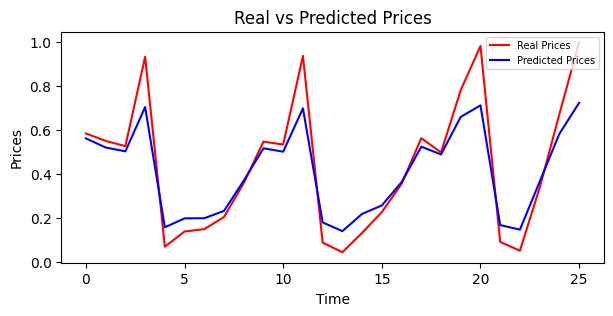

In [59]:
plt.figure(figsize=(7,3))
plt.plot(y_test_1,'red',label='Real Prices')
plt.plot(predicted_value_1,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=7)

In [60]:
print("MAE: ", mean_absolute_error(y_test_1, predicted_value_1))
print("RMSE: ", np.sqrt(mean_squared_error(y_test_1, predicted_value_1)))
print("R2 Score: ", r2_score(y_test_1, predicted_value_1))

MAE:  0.08298396736222051
RMSE:  0.11483107848136978
R2 Score:  0.8591823560499326


Prediction with sentiment scores using GRU

In [61]:
X_2 = df.drop(['Date', 'Adj Close'], axis = 1)
y_2 = df.iloc[:, 4:5]

In [62]:
# X = df[['sentiment score']]

In [63]:
scaler = MinMaxScaler()
X_normalized_2 = scaler.fit_transform(X_2)
y_normalized_2 = scaler.fit_transform(y_2)

i_split = int(len(df) * 0.9)

X_train_2 = X_normalized_2[:i_split, :]
y_train_2 = y_normalized_2[:i_split, :]
X_test_2 = X_normalized_2[i_split:,:]
y_test_2 = y_normalized_2[i_split:,:]

In [64]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
X_train_new_2 = np.reshape(X_train_2,(X_train_2.shape[0],X_train_2.shape[1],1))

In [65]:
model_2 = Sequential()
model_2.add(GRU(units=5, return_sequences = True, input_shape = (X_train_new_2.shape[1],1)))  # 256, return_sequences = True
model_2.add(GRU(units=3, recurrent_dropout = 0.2)) #, return_sequences = True
model_2.add(Dense(units=1))

In [66]:
model_2.compile(optimizer = 'adam',loss = 'mean_squared_error')
history_2 = model_2.fit(X_train_2, y_train_2, batch_size = 10, epochs = 10)

Epoch 1/10
23/23 [==============================] - 6s 8ms/step - loss: 0.1432
Epoch 2/10
23/23 [==============================] - 0s 8ms/step - loss: 0.1018
Epoch 3/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0706
Epoch 4/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0558
Epoch 5/10
23/23 [==============================] - 0s 9ms/step - loss: 0.0527
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0495
Epoch 7/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0468
Epoch 8/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0422
Epoch 9/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0380
Epoch 10/10
23/23 [==============================] - 0s 9ms/step - loss: 0.0309


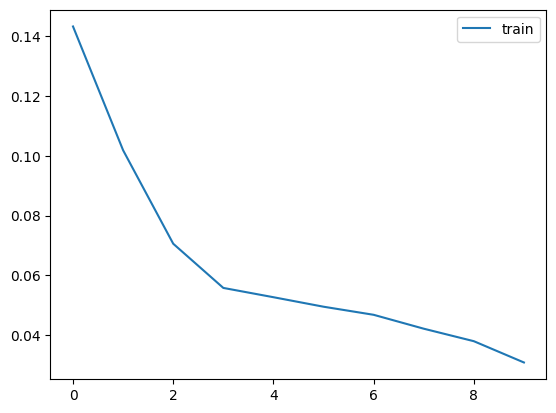

In [67]:
pyplot.plot(history_2.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [68]:
model_2.save('/content/drive/MyDrive/BeProject/model_2.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
model_2 = load_model('/content/drive/MyDrive/BeProject/model_2.h5')

In [70]:
X_test_new_2 = np.reshape(X_test_2,(X_test_2.shape[0], X_test_2.shape[1],1))
predicted_value_2 = model_2.predict(X_test_new_2)

1/1 [==============================] - 2s 2s/step


In [71]:
y_test_2

array([[0.58481339],
       [0.55090254],
       [0.52693763],
       [0.93372549],
       [0.0693909 ],
       [0.13870286],
       [0.14959286],
       [0.2046427 ],
       [0.35928112],
       [0.54753991],
       [0.53453126],
       [0.93735659],
       [0.08827868],
       [0.04449139],
       [0.13282056],
       [0.22688998],
       [0.35561219],
       [0.56323231],
       [0.49855232],
       [0.78202664],
       [0.98280783],
       [0.09136032],
       [0.0513967 ],
       [0.33770009],
       [0.67265321],
       [1.        ]])

In [72]:
predicted_value_2

array([[0.45136195],
       [0.41925168],
       [0.44176188],
       [0.5495308 ],
       [0.21903333],
       [0.2906737 ],
       [0.26831323],
       [0.29242346],
       [0.34029245],
       [0.44777125],
       [0.39955083],
       [0.5733173 ],
       [0.29856527],
       [0.17680255],
       [0.27460003],
       [0.31329286],
       [0.3269791 ],
       [0.45268607],
       [0.43638384],
       [0.5148559 ],
       [0.56769866],
       [0.2053568 ],
       [0.1726703 ],
       [0.3594859 ],
       [0.50479674],
       [0.56893253]], dtype=float32)

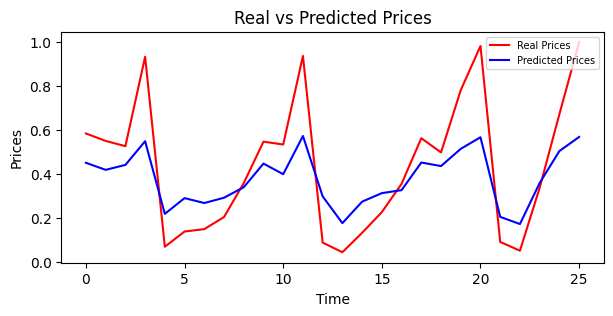

In [73]:
plt.figure(figsize=(7,3))
plt.plot(y_test_2,'red',label='Real Prices')
plt.plot(predicted_value_2,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=7)

In [74]:
print("MAE: ", mean_absolute_error(y_test_2, predicted_value_2))
print("RMSE: ", np.sqrt(mean_squared_error(y_test_2, predicted_value_2)))
print("R2 Score: ", r2_score(y_test_2, predicted_value_2))

MAE:  0.16041353075989712
RMSE:  0.19713476953202563
R2 Score:  0.584984186282494


Predcition with sentiment score LSTM


In [75]:
X_3 = df.drop(['Date', 'Adj Close'], axis = 1)
y_3 = df.iloc[:, 4:5]

In [76]:
# X = df[['sentiment score']]

In [77]:
scaler = MinMaxScaler()
X_normalized_3 = scaler.fit_transform(X_3)
y_normalized_3 = scaler.fit_transform(y_3)

i_split = int(len(df) * 0.9)

X_train_3 = X_normalized_3[:i_split, :]
y_train_3 = y_normalized_3[:i_split, :]
X_test_3 = X_normalized_3[i_split:,:]
y_test_3 = y_normalized_3[i_split:,:]

In [78]:
#Reshaping the train data to make it as input for LTSM layer input_shape(batchzise,timesteps,input_dim)
X_train_new_3 = np.reshape(X_train_3,(X_train_3.shape[0],X_train_3.shape[1],1))

In [79]:
model_3 = Sequential()

model_3.add(LSTM(units = 5,kernel_initializer='glorot_uniform',return_sequences=True,input_shape=(X_train_new_3.shape[1],1)))

model_3.add(LSTM(units = 2,kernel_initializer='glorot_uniform'))

model_3.add(Dense(units = 1))

In [80]:
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_3.fit(X_train_3, y_train_3, batch_size = 10, epochs = 10)

Epoch 1/10
23/23 [==============================] - 6s 8ms/step - loss: 0.0590
Epoch 2/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0337
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 4/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 5/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 7/10
23/23 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 8/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 9/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 10/10
23/23 [==============================] - 0s 7ms/step - loss: 0.0022


In [82]:
model_3.save('/content/drive/MyDrive/BeProject/model_3.h5')

In [83]:
model_3 = load_model('/content/drive/MyDrive/BeProject/model_3.h5')

In [84]:
X_test_new_3 = np.reshape(X_test_3,(X_test_3.shape[0], X_test_3.shape[1],1))
predicted_value_3 = model_3.predict(X_test_new_3)

1/1 [==============================] - 2s 2s/step


In [85]:
y_test_3

array([[0.58481339],
       [0.55090254],
       [0.52693763],
       [0.93372549],
       [0.0693909 ],
       [0.13870286],
       [0.14959286],
       [0.2046427 ],
       [0.35928112],
       [0.54753991],
       [0.53453126],
       [0.93735659],
       [0.08827868],
       [0.04449139],
       [0.13282056],
       [0.22688998],
       [0.35561219],
       [0.56323231],
       [0.49855232],
       [0.78202664],
       [0.98280783],
       [0.09136032],
       [0.0513967 ],
       [0.33770009],
       [0.67265321],
       [1.        ]])

In [86]:
predicted_value_3

array([[ 0.62006867],
       [ 0.56597114],
       [ 0.5639373 ],
       [ 0.80074716],
       [ 0.04055357],
       [ 0.1585447 ],
       [ 0.14041346],
       [ 0.20036884],
       [ 0.37263197],
       [ 0.5783613 ],
       [ 0.53816867],
       [ 0.7950766 ],
       [ 0.13896292],
       [-0.02120801],
       [ 0.16005646],
       [ 0.24109714],
       [ 0.35569024],
       [ 0.58751464],
       [ 0.5468688 ],
       [ 0.7460569 ],
       [ 0.8092841 ],
       [ 0.04010039],
       [-0.01908704],
       [ 0.38288173],
       [ 0.6606108 ],
       [ 0.8216388 ]], dtype=float32)

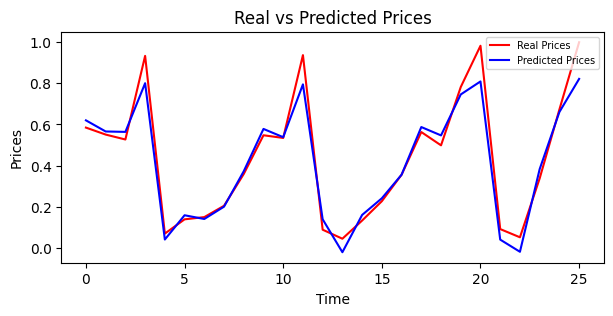

In [87]:
plt.figure(figsize=(7,3))
plt.plot(y_test_3,'red',label='Real Prices')
plt.plot(predicted_value_3,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=7)

In [88]:
print("MAE: ", mean_absolute_error(y_test_3, predicted_value_3))
print("RMSE: ", np.sqrt(mean_squared_error(y_test_3, predicted_value_3)))
print("R2 Score: ", r2_score(y_test_3, predicted_value_3))

MAE:  0.04884037925997227
RMSE:  0.06988646624467891
R2 Score:  0.9478415893941396


Time Series LSTM

In [89]:
data = df.drop(['Date', 'Adj Close'], axis = 1)
dataset = data.values

training_data_length = math.ceil(len(dataset) * 0.9)

In [90]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [91]:
train_data = scaled_data[:training_data_length, :]
x_train = []
y_train = []

for i in range(10, len(train_data)):
  x_train.append(train_data[i-10:i, 0])
  y_train.append(train_data[i, 0])

In [92]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [93]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [94]:
# model = Sequential()
# model.add(LSTM(5, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(LSTM(3, return_sequences=False))
# model.add(Dense(1))

model = Sequential()

model.add(LSTM(units = 128,kernel_initializer='glorot_uniform',return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=75,kernel_initializer='glorot_uniform',return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [95]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [96]:
model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
22/22 [==============================] - 9s 25ms/step - loss: 0.0784
Epoch 2/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0670
Epoch 3/100
22/22 [==============================] - 0s 20ms/step - loss: 0.0656
Epoch 4/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0630
Epoch 5/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0562
Epoch 6/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0510
Epoch 7/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0477
Epoch 8/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0452
Epoch 9/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0480
Epoch 10/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0434
Epoch 11/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0410
Epoch 12/100
22/22 [==============================] - 1s 27ms/step - loss: 0.0432
Epoch 13/100
22/22 [=====

In [98]:
model.save('/content/drive/MyDrive/BeProject/model_4.h5')

In [99]:
model = load_model('/content/drive/MyDrive/BeProject/model_4.h5')

In [100]:
test_data = scaled_data[training_data_length - 10:, :]

x_test = []
y_test = scaled_data[training_data_length: , 0]

for i in range(10, len(test_data)):
  x_test.append(test_data[i - 10: i, 0])

In [101]:
x_test = np.array(x_test)

In [102]:
y_test

array([0.54427138, 0.52940663, 0.94148157, 0.05799783, 0.12492081,
       0.13489341, 0.18977403, 0.35435625, 0.54492994, 0.52855987,
       0.9234494 , 0.07715272, 0.03505773, 0.14581307, 0.21413786,
       0.34759184, 0.55344427, 0.5121427 , 0.82607553, 0.96531544,
       0.07781757, 0.04330864, 0.34878666, 0.65726274, 1.        ])

In [103]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [104]:
predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions) #unscaling values

1/1 [==============================] - 2s 2s/step


In [105]:
predictions

array([[0.5467654 ],
       [0.6146119 ],
       [0.4186483 ],
       [0.07109256],
       [0.07302377],
       [0.14120871],
       [0.26740602],
       [0.4133854 ],
       [0.51849854],
       [0.5583584 ],
       [0.59318435],
       [0.37947202],
       [0.09805423],
       [0.11360285],
       [0.22845471],
       [0.37941328],
       [0.49841315],
       [0.5499829 ],
       [0.6058946 ],
       [0.4047543 ],
       [0.06850126],
       [0.06766951],
       [0.14433971],
       [0.27870846],
       [0.37912244]], dtype=float32)

In [106]:
y_test

array([0.54427138, 0.52940663, 0.94148157, 0.05799783, 0.12492081,
       0.13489341, 0.18977403, 0.35435625, 0.54492994, 0.52855987,
       0.9234494 , 0.07715272, 0.03505773, 0.14581307, 0.21413786,
       0.34759184, 0.55344427, 0.5121427 , 0.82607553, 0.96531544,
       0.07781757, 0.04330864, 0.34878666, 0.65726274, 1.        ])

In [107]:
print("MAE: ", mean_absolute_error(y_test, predictions))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
print("R2 Score: ", r2_score(y_test, predictions))

MAE:  0.1503931741586592
RMSE:  0.2399798810060974
R2 Score:  0.41698360299297543
